In [273]:
import os
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import joblib

In [8]:
data_dir = "../examples/experiments/results_retrain/pm_exp_whas/"

In [167]:
trace_retrain = az.from_netcdf(os.path.join(data_dir, '1', 'retrain', '3', 'model.yaml.netcdf'))

In [168]:
# az.plot_posterior(trace_retrain, filter_vars='like', var_names=['~det']);

In [169]:
trace_full = az.from_netcdf(os.path.join(data_dir, '1', 'full', '3', 'model.yaml.netcdf'))

In [170]:
# az.plot_posterior(trace_full, filter_vars='like', var_names=['~det']);

In [171]:
excludes = ['lambda_det', 'lambda_yrgrp_1975 & 1978', 'lambda_yrgrp_1981 & 1984', 'lambda_yrgrp_1986 & 1988']

0.9966206622998728 0.9965167016771486 0.6261468860840975


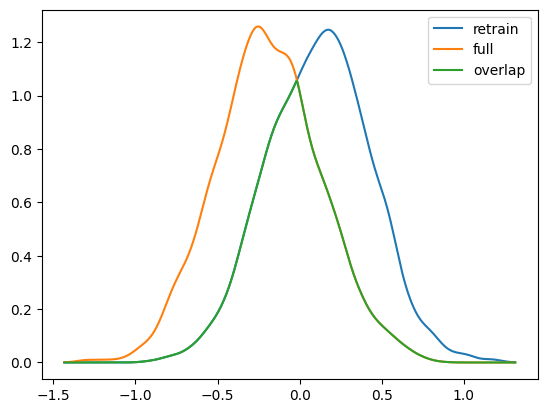

In [188]:
var_name = 'lambda_chf'
trace_1 = trace_retrain.posterior[var_name].values.flatten()
trace_2 = trace_full.posterior[var_name].values.flatten()
cmin = np.min([trace_1, trace_2]) - 0.1
cmax = np.max([trace_1, trace_2]) + 0.1
grid1, pdf1 = az.kde(trace_1, custom_lims=(cmin, cmax))
grid2, pdf2 = az.kde(trace_2, custom_lims=(cmin, cmax))

overlap = np.min(np.stack([pdf1, pdf2]), axis=0)

auc_1 = -np.trapz(grid1, pdf1)
auc_2 = -np.trapz(grid2, pdf2)
auc_overlap = -np.trapz(grid1, overlap)

print(auc_1, auc_2, auc_overlap)

plt.plot(grid1, pdf1, label='retrain');
plt.plot(grid2, pdf2, label='full');
plt.plot(grid1, overlap, label='overlap');
plt.legend();

In [173]:
def compare_posterior(trace_1, trace_2, var_name):
    az.plot_dist(trace_1.posterior[var_name], color='C0', label='Re training');
    az.plot_dist(trace_2.posterior[var_name], color='C1', label='Full training');
    # grid1, pdf1 = az.kde(trace_1.posterior[var_name])
    # grid2, pdf2 = az.kde(trace_2.posterior[var_name])
    plt.ylabel('Density')
    plt.title(var_name)
    plt.legend(frameon=False)

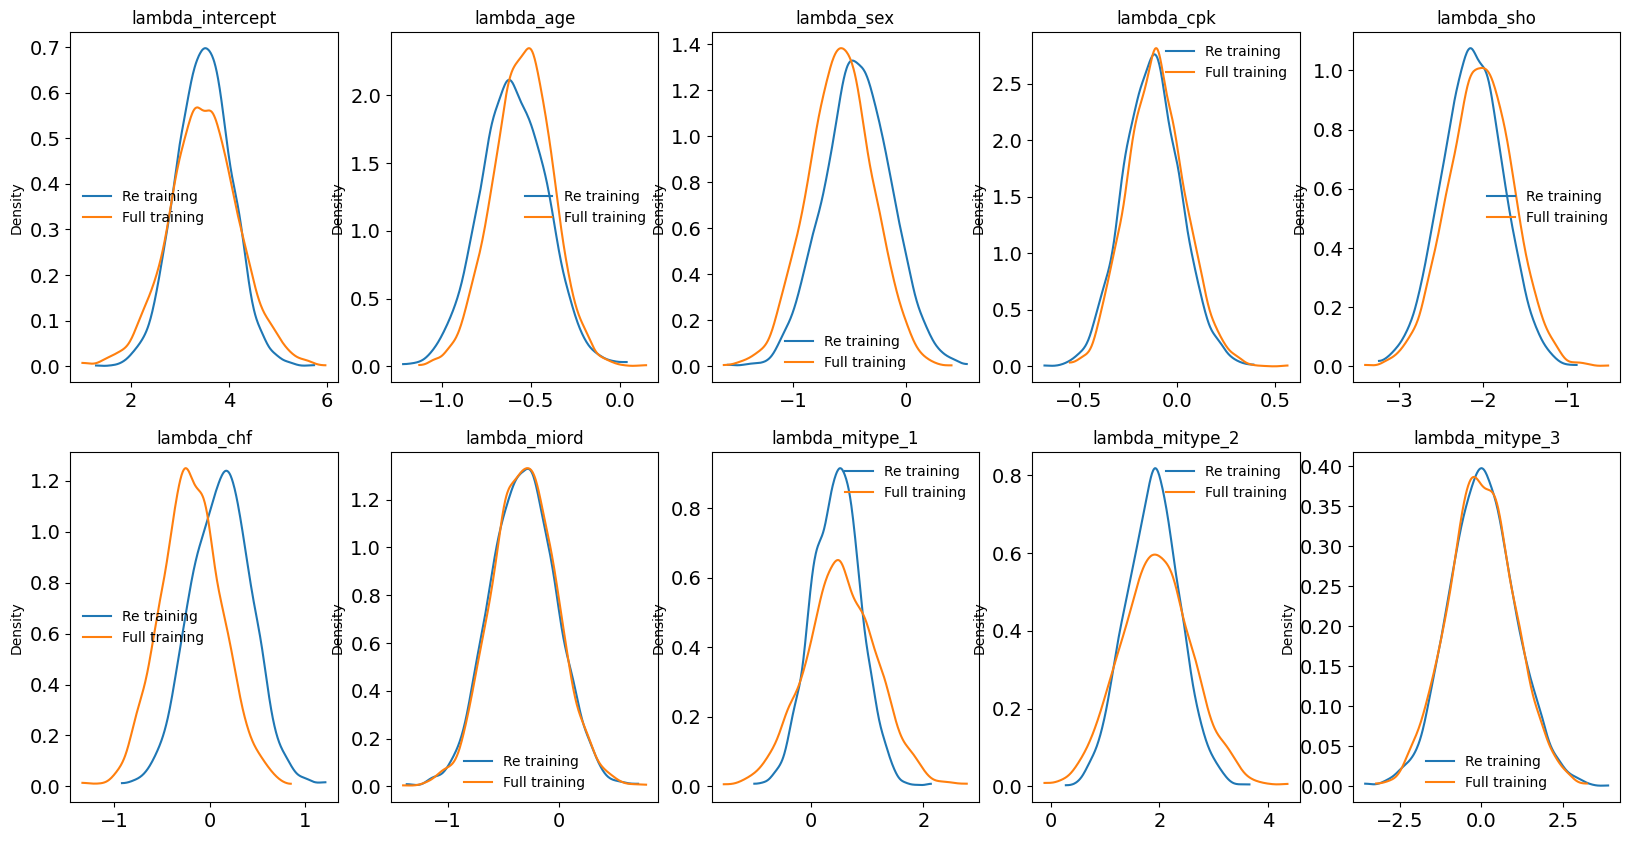

In [174]:
plt.figure(figsize=(20, 10))
for i, d_var in enumerate(trace_retrain.posterior.data_vars):
    if d_var in excludes:
        continue
    plt.subplot(2, 5, i+1) 
    compare_posterior(trace_retrain, trace_full, d_var)

In [435]:
az.plot_dist(trace_retrain.posterior["lambda_cpk"], color='C0', label='Re training')
az.plot_dist(trace_full.posterior["lambda_cpk"], color='C1', label='Full training')
plt.ylabel('Density')
plt.title('lambda_cpk')
plt.legend(frameon=False)

KeyError: 'lambda_cpk'

In [298]:
data_full = joblib.load(os.path.join(run_dir, 'full', str(partition), 'data.pkl'))
data_re = joblib.load(os.path.join(run_dir, 'retrain', str(partition), 'data.pkl'))

In [387]:
y_predictions_re = data_re[4][0]
y_predictions_full = data_full[4][0]

In [330]:
y_med_re = np.median(y_predictions_re, axis=1)
y_med_full = np.median(y_predictions_full, axis=1)
y_med_diff = (y_med_full - y_med_re)

In [391]:
from scipy.interpolate import interp1d
from scipy.signal import resample, resample_poly

In [350]:
t_re.shape
y_predictions_full.shape

(71, 711)

In [356]:
t_re = np.repeat(np.linspace(0, 1, y_predictions_re.shape[1]), y_predictions_re.shape[0]).reshape(y_predictions_re.shape)
t_re.shape

(71, 241)

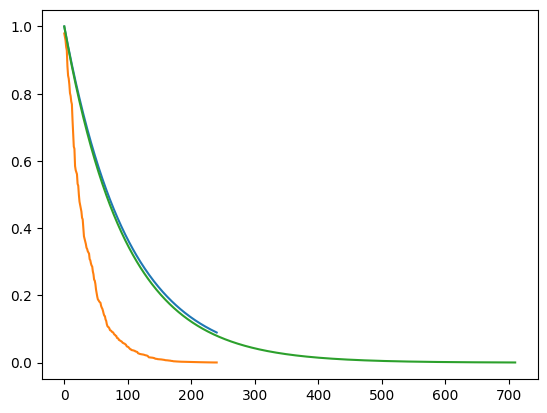

In [419]:
plt.plot(y_predictions_re[0]);
# y_predictions_full_ = resample_poly(y_predictions_full, y_predictions_re.shape[1], axis=1)
# print(y_predictions_full_.shape, y_predictions_re.shape[1])
y_predictions_full_ = np.flip(np.sort(np.random.choice(y_predictions_full[0], y_predictions_re.shape[1], replace=False)))
plt.plot(y_predictions_full_);
plt.plot(y_predictions_full[0]);

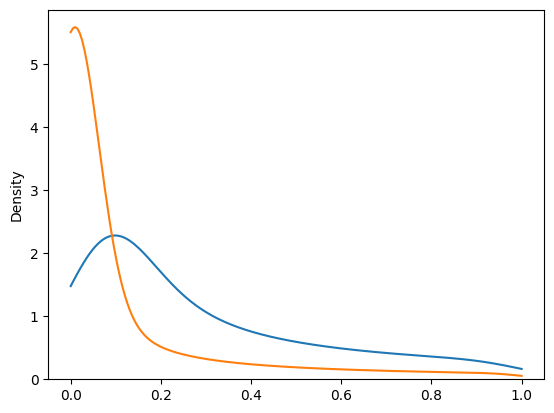

In [420]:
sns.kdeplot(y_predictions_re[idx], clip=(0, 1));
sns.kdeplot(y_predictions_full[idx], clip=(0, 1));

(71, 711) (71, 711)
0.4032589168113103


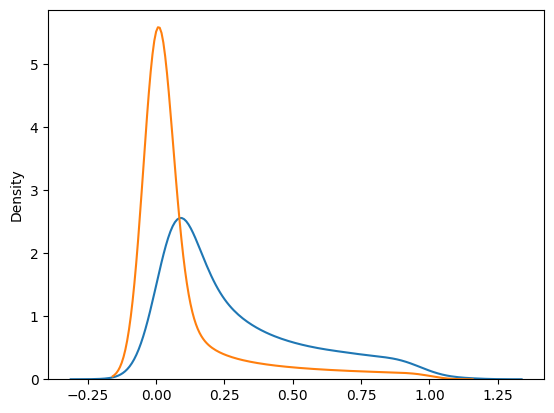

In [385]:
idx = 1
sns.kdeplot(y_predictions_re[idx]);
sns.kdeplot(y_predictions_full[idx]);
# t_re = np.linspace(0, 1, y_predictions_re.shape[1])
# t_full = np.linspace(0, 1, y_predictions_full.shape[1]).reshape(y_predictions_full.shape[1])

if y_predictions_re.shape[1] > y_predictions_full.shape[1]:
    y_predictions_full = resample(y_predictions_full, y_predictions_re.shape[1], axis=1)
    # y_predictions_full_ = interp1d(t_re, y_predictions_full[0], bounds_error=False)
else:
    y_predictions_re = resample(y_predictions_re, y_predictions_full.shape[1], axis=1)
    # y_predictions_re_ = interp1d(t_full, y_predictions_re[0], bounds_error=False)
print(y_predictions_re.shape,  y_predictions_full.shape)
ovi = overlap_index(y_predictions_re[idx][:], y_predictions_full[idx][:])
print(ovi)

# Collect data

In [421]:
import pandas as pd

In [527]:
data_dir = "../examples/experiments/results_retrain/pm_exp_whas/"

In [528]:
def overlap_index(trace1, trace2):
    cmin = np.min([trace1, trace2]) - 0.1
    cmax = np.max([trace1, trace2]) + 0.1
    grid1, pdf1 = az.kde(trace1, custom_lims=(cmin, cmax))
    grid2, pdf2 = az.kde(trace2, custom_lims=(cmin, cmax))
    
    overlap = np.min(np.stack([pdf1, pdf2]), axis=0) 
    
    auc_1 = -np.trapz(grid1, pdf1)
    auc_2 = -np.trapz(grid2, pdf2)
    scale_factor = 1 / np.mean([auc_1, auc_2])
    auc_overlap = -np.trapz(grid1, overlap) * scale_factor
    
    return auc_overlap

In [529]:
excludes = ['lambda_det']

In [531]:
results = pd.DataFrame({ 'model': [],  'run': [],  'partition': [],  'var': [],  'posterior_retrain': [],  'posterior_full': [], 'ovi': [] })

pbar = tqdm(range(0, 3))
for run in pbar:
    run_dir = os.path.join(data_dir, str(run))
    for partition in range(1, 6):
        pbar.set_description(f"{run} / {partition}")
        try:
            file_retrain = os.path.join(run_dir, 'retrain', str(partition), 'model.yaml.netcdf')
            file_full = os.path.join(run_dir, 'full', str(partition), 'model.yaml.netcdf')
            file_data = os.path.join(run_dir, 'full', str(partition), 'data.pkl')

            trace_retrain = az.from_netcdf(file_retrain)
            trace_full = az.from_netcdf(file_full)
        except:
            print(f"{file_retrain} failed...")
            print(f"{file_full} failed...")
            continue
        
        for i, d_var in enumerate(trace_retrain.posterior.data_vars):
            if d_var in excludes:
                continue
        
            trace_var_retrain = trace_retrain.posterior[d_var].values.flatten()
            trace_var_full = trace_full.posterior[d_var].values.flatten()
            ovi = overlap_index(trace_var_retrain, trace_var_full)
            
            results = pd.concat([results, pd.DataFrame({
                'model': ['pm_exp'],  
                'run': [run],  
                'partition': [partition],  
                'var': [d_var],  
                'posterior_retrain': [trace_var_retrain],  
                'posterior_full': [trace_var_full], 
                'ovi': [ovi] 
                })
             ])
        

1 / 1:  33%|█████████████████████████████████████████████████████████████████▎                                                                                                                                  | 1/3 [00:01<00:03,  1.99s/it]

../examples/experiments/results_retrain/pm_exp_whas/0/retrain/5/model.yaml.netcdf failed...
../examples/experiments/results_retrain/pm_exp_whas/0/full/5/model.yaml.netcdf failed...


2 / 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.26s/it]


In [431]:
results.to_csv(os.path.join(data_dir, 'ovi.csv'))

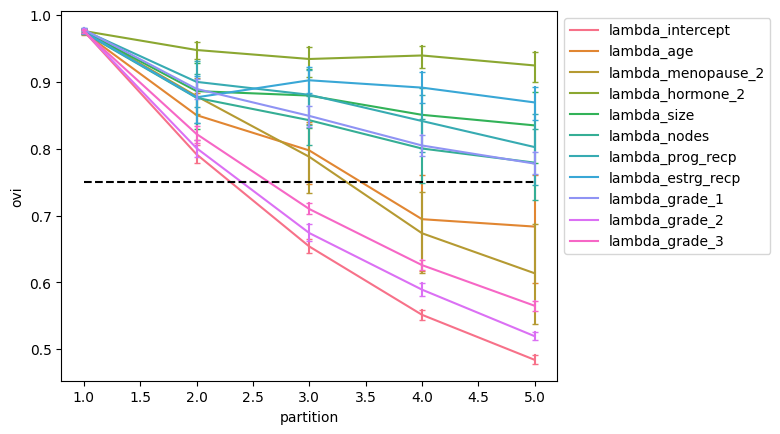

In [433]:
sns.lineplot(data=results, y='ovi', x='partition', hue='var', 
             err_style='bars', errorbar='ci', err_kws={'capsize': 2.5});
plt.legend(bbox_to_anchor=(1, 1), loc = 'upper left', ncol=1);
plt.hlines(y=0.75, xmin=1, xmax=5, linestyles='dashed', color='black');

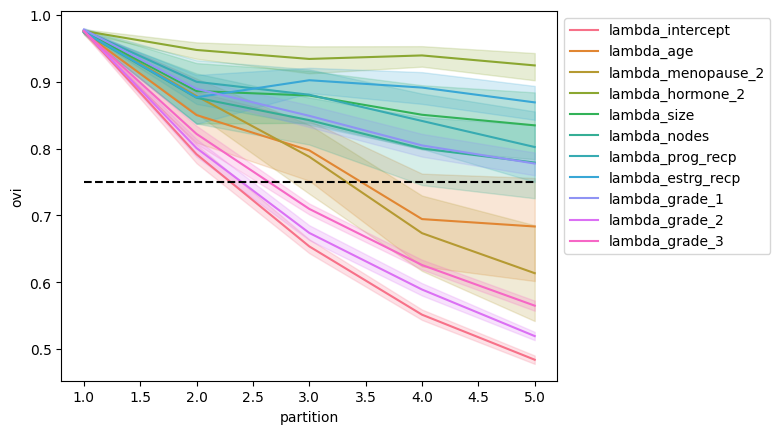

In [434]:
sns.lineplot(data=results, y='ovi', x='partition', hue='var', 
             err_style='band');
plt.legend(bbox_to_anchor=(1, 1), loc = 'upper left', ncol=1);
plt.hlines(y=0.75, xmin=1, xmax=5, linestyles='dashed', color='black');

In [447]:
results.shape[0]/5/19

11.0

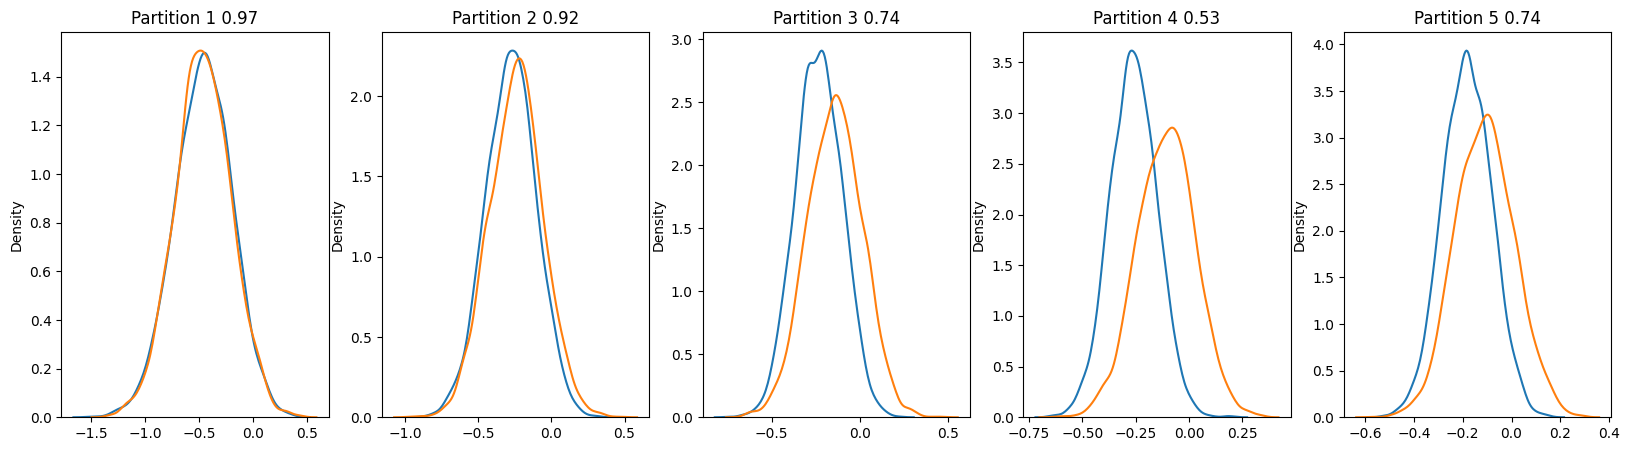

In [493]:
results_age = results[results['var'] == 'lambda_age']
results_age = results_age[results_age['run'] == 55]

plt.figure(figsize=(20, 5))
ax = plt.subplot(1, 5, 1)
ax.set_title(f"Partition 1 {results_age.iloc[0]['ovi']:0.2f}")
sns.kdeplot(results_age.iloc[0]['posterior_retrain']);
sns.kdeplot(results_age.iloc[0]['posterior_full']);

ax = plt.subplot(1, 5, 2)
ax.set_title(f"Partition 2 {results_age.iloc[1]['ovi']:0.2f}")
sns.kdeplot(results_age.iloc[1]['posterior_retrain']);
sns.kdeplot(results_age.iloc[1]['posterior_full']);

ax = plt.subplot(1, 5, 3)
ax.set_title(f"Partition 3 {results_age.iloc[2]['ovi']:0.2f}")
sns.kdeplot(results_age.iloc[2]['posterior_retrain']);
sns.kdeplot(results_age.iloc[2]['posterior_full']);

ax = plt.subplot(1, 5, 4)
ax.set_title(f"Partition 4 {results_age.iloc[3]['ovi']:0.2f}")
sns.kdeplot(results_age.iloc[3]['posterior_retrain']);
sns.kdeplot(results_age.iloc[3]['posterior_full']);

ax = plt.subplot(1, 5, 5)
ax.set_title(f"Partition 5 {results_age.iloc[4]['ovi']:0.2f}")
sns.kdeplot(results_age.iloc[4]['posterior_retrain']);
sns.kdeplot(results_age.iloc[4]['posterior_full']);


In [478]:
from scipy.stats import gaussian_kde

In [490]:
def median_diff(posterior1, posterior2):
    dens1 = gaussian_kde(posterior1)
    dens2 = gaussian_kde(posterior2)
    
    xs = np.linspace(-2, 2, 200)
    
    max_1 = xs[np.argmax(dens1(xs))]
    max_2 = xs[np.argmax(dens2(xs))]
    
    med_diff = max_1 - max_2
    return med_diff

-0.14
-0.18
-0.06
-0.16
-0.28


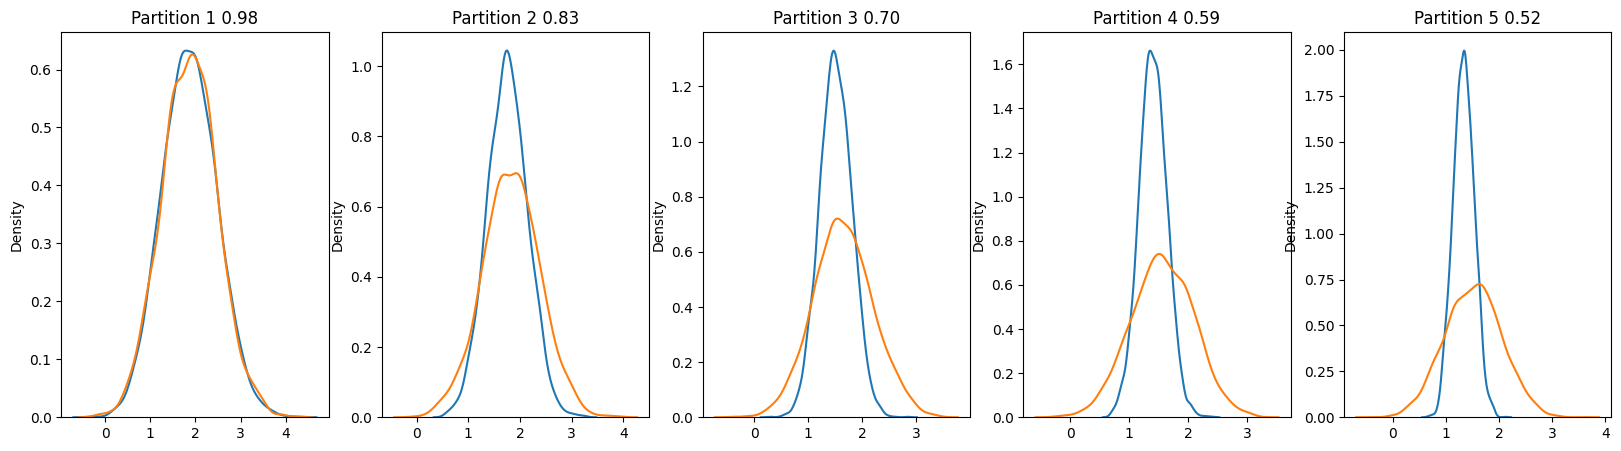

In [491]:
results_age = results[results['var'] == 'lambda_grade_3']
results_age = results_age[results_age['run'] == 52]

plt.figure(figsize=(20, 5))
ax = plt.subplot(1, 5, 1)
ax.set_title(f"Partition 1 {results_age.iloc[0]['ovi']:0.2f}")
sns.kdeplot(results_age.iloc[0]['posterior_retrain']);
sns.kdeplot(results_age.iloc[0]['posterior_full']);
      
ax = plt.subplot(1, 5, 2)
ax.set_title(f"Partition 2 {results_age.iloc[1]['ovi']:0.2f}")
sns.kdeplot(results_age.iloc[1]['posterior_retrain']);
sns.kdeplot(results_age.iloc[1]['posterior_full']);

ax = plt.subplot(1, 5, 3)
ax.set_title(f"Partition 3 {results_age.iloc[2]['ovi']:0.2f}")
sns.kdeplot(results_age.iloc[2]['posterior_retrain']);
sns.kdeplot(results_age.iloc[2]['posterior_full']);

ax = plt.subplot(1, 5, 4)
ax.set_title(f"Partition 4 {results_age.iloc[3]['ovi']:0.2f}")
sns.kdeplot(results_age.iloc[3]['posterior_retrain']);
sns.kdeplot(results_age.iloc[3]['posterior_full']);

ax = plt.subplot(1, 5, 5)
ax.set_title(f"Partition 5 {results_age.iloc[4]['ovi']:0.2f}")
sns.kdeplot(results_age.iloc[4]['posterior_retrain']);
sns.kdeplot(results_age.iloc[4]['posterior_full']);


In [525]:
results_posterior = pd.DataFrame({ 'model': [], 'run': [], 'partition': [], 'var': [],  'posterior_type': [],  'posterior': []})

results_run = results[results['run'] == 55]

for i in tqdm(range(0, results_run.shape[0])):
    for post_type in ['posterior_retrain', 'posterior_full']:
        # grid, posterior_kde = az.kde()
        n_posterior = len(results_run.iloc[i][post_type])
        results_posterior = pd.concat([results_posterior, pd.DataFrame({
                'model': np.repeat(results_run.iloc[i]['model'], n_posterior),
                'run': np.repeat(results_run.iloc[i]['run'], n_posterior),
                'partition': np.repeat(results_run.iloc[i]['partition'], n_posterior),
                'var': np.repeat(results_run.iloc[i]['var'], n_posterior),
                'posterior_type': np.repeat(post_type, n_posterior),
                'posterior': results_run.iloc[i][post_type],
                # 'posterior_grid': grid
            })
        ])

results_posterior

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:02<00:00, 24.78it/s]


,model,run,partition,var,posterior_type,posterior
0,pm_exp,55.0,1.0,lambda_intercept,posterior_retrain,5.846498
1,pm_exp,55.0,1.0,lambda_intercept,posterior_retrain,6.054579
2,pm_exp,55.0,1.0,lambda_intercept,posterior_retrain,6.648581
3,pm_exp,55.0,1.0,lambda_intercept,posterior_retrain,6.480845
4,pm_exp,55.0,1.0,lambda_intercept,posterior_retrain,6.503891
...,...,...,...,...,...,...
3995,pm_exp,55.0,5.0,lambda_grade_3,posterior_full,1.668223
3996,pm_exp,55.0,5.0,lambda_grade_3,posterior_full,2.668004
3997,pm_exp,55.0,5.0,lambda_grade_3,posterior_full,1.540192
3998,pm_exp,55.0,5.0,lambda_grade_3,posterior_full,1.286852


In [526]:
results_posterior.to_csv(os.path.join(data_dir, 'full_posteriors.csv'))